In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
true = True
false = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

name_of_image = 'Presentations/22_05_11/rad_110'
save_figures_general = False
save_figures_dense = False
save_figures_conv = False

# Название файла откуда считываются обработанные данные
name_of_file = 'PD110_time_no_empty'                                          # Основной с распределенными столкновениями, время - прямое
# name_of_file = 'PD114_time_inv_0coord'                                      # Основной столкновния в нуле, время - обратное  

include_coord_feature = False
bias_time_by_coord = False
undersampling_enable = False
oversampling_enable = False
only_time_feature = False
is_made_uniform_batch = False

acc_to_restore = 0.001 # 0.03
number_of_epoches_lin = 100        # Количество эпох в обучении полносвязной нейросети
number_of_epoches_conv = 100      # Количество эпох в обучении сверточной нейросети
batch_size_N = 800                    # Размер батча
training_set_part = 0.8             # Часть от 0 до 1 выделяемая на тренировочный набор
to_predict = [0]
loss_weights = [1, 1, 1]
threshold = 5
# to_predict = [0, 1]          # Что предсказывать: 0 - прицельный параметр, 1 - координата, 2 - угол 

name_of_label = ['impact parameter','coordinate', 'time of first particle']

n_out = len(to_predict)
dot_size = 0.3

# norms = [200, 32, 6]
norms = [10, 32, 6]
# norms = [10, 4, 6]
# norms = [200, 4, 8, 6]

avg_pion_times = [3.345, 5.675, 8.355]
input_data = []
times_of_first_particles = []

imp_parameters = []

with open('data/' + name_of_file + '.dat', 'r') as inpf: 
    l = inpf.readline()
    s = l.strip().split()

    # Чтение максимального количества данных в строке и количества строк для одного события
    maximum_hits = int(s[2])
    n_lines = int(s[4])
    
    if only_time_feature:
        n_lines = 1
        
    number_of_features = n_lines * maximum_hits

    if include_coord_feature:
        number_of_features += 1
    print(l)
    max_b = 0.0
    max_coord = 0.0
    max_phi = 0.0
    norm_labels = True

    amount = 0
    for line in inpf:
        if True:
            features = []
            s = line.strip().split()
            b = float(s[0])
            coord = float(s[1])
            phi_b = float(s[2])

            if norm_labels:
                max_b = max(b, max_b)
                max_phi = max(abs(phi_b), max_phi)
                max_coord = max(abs(coord), max_coord)

            imp_parameters.append(b)

            n = 0
            # investigated_det = 1
            for digit in s[3:]:
                if True:#(n == 1) or (n == 0)  :#or n == 12:#( 11 < n < 18):                      # *
                # if n == investigated_det - 1 or n == investigated_det + 11 :
                    #if float(digit) > 0:                                                                   # *
                    if True:  
                        if n < maximum_hits:
                            features.append(float(digit) / norms[0])
                        elif only_time_feature:
                            break                             
                        elif n < maximum_hits * 2:
                            val = float(digit)
                            features.append(val / norms[1])
                        elif n < maximum_hits * 3:
                            features.append(float(digit) / norms[2])
                        elif n < maximum_hits * 4:
                            features.append(float(digit) / norms[3])
                        else:
                            features.append(float(digit) / norms[4])
                
                

                n += 1
                '''
                features.append(float(digit))
                '''
            
            if bias_time_by_coord:
            # if amount < 4:
                coord_with_error = (coord // acc_to_restore) * acc_to_restore
                # print(coord_with_error)
                time_bias = coord_with_error / 0.29895366218236173393124065769806
                for i in range(maximum_hits):
                    if features[2 * maximum_hits+ i ] < 0.001:
                        break
                    if (int(features[2 * maximum_hits + i] * 6) % 2):
                        features[i] -= time_bias / norms[0]
                    else:
                        features[i] += time_bias / norms[0]
                    n_ring = (int(features[2 * maximum_hits + i] * 6 - 1) // 2)
                    p_time = features[i] * norms[0]
                    # print(p_time)
                    p_time -= avg_pion_times[n_ring]
                    if abs(p_time) < 0.005:
                        p_time = 200
                    else: 
                        p_time = 1/p_time
                    # print(p_time)
                    features[i] = p_time / 200

            
            if include_coord_feature:    
                features.append(coord)
            # if len(features) > 0:
            if True:#len(features) > 1:
                times_of_first_particles.append(float(s[3]))
                input_data.append([b, coord, phi_b, features])   
            # input_data.append([b, coord, features])
            amount += 1

            
maximum_values = [max_b, max_coord, max_phi] 
print(input_data[0])
if include_coord_feature:
    number_of_features += 1
# [0.16749999523162842, 0.16749999523162842, 0.28499999046325686, 0.0, 0.0, 0.0, 0.25, 0.1875, 0.96875, 0.0, 0.0, 0.0, 0.16666666666666666, 0.3333333333333333, 0.5, 0.0, 0.0, 0.0]]

cuda:0
Maximum hits: 60 Lines: 3

[0.034, -0.03497845847419082, 2.782821983319221, [0.32, 0.32, 0.35, 0.5549999999999999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.84375, 0.25, 0.1875, 0.96875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 0.16666666666666666, 0.3333333333333333, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [46]:
# Создание класса для набора данных с двумя функциями
class DatasetNN(torch.utils.data.Dataset):
    def __init__(self, labels, features):           # В этом методе создаются две переменные для характеристик и для меток
        self.labels = labels
        self.features = features

    def __len__(self):                       # Эта функция должна возвращать размер набора данных
        return self.labels.shape[0]

    def __getitem__(self, idx):              # Эта функция возвращает один (или несколько, зависит от размерности переменной idx) из примеров данных с индексом idx
        if torch.is_tensor(idx):             # Если набор индексов задан как тензор, то приведение его к виду списка       
            idx = idx.tolist()

        label = self.labels[idx]

        feature = self.features[idx]
        
        sample = {'label': label, 'feature': feature}   # Возвращает пример (набор примеров) в виде словаря (пара метка-характеристика)

        return sample

def norm_label(value: float, label_idx: int) -> float:
    if label_idx == 0:
        res = (value * 2 / maximum_values[0]) - 1.0
        return res
    else:
        res = value / maximum_values[label_idx]
        return res


def get_correct_predictions_binary(preds: torch.Tensor, values: torch.Tensor, threshold: float) -> torch.Tensor:
    confusion_matrix = torch.zeros((2,2))
    normed_threshold = norm_label(threshold, 0)
    for i in range(preds.shape[0]):
        pred_is_big = preds[i][0].item() >= normed_threshold
        value_is_big = values[i].item() >= normed_threshold
        confusion_matrix[int(value_is_big)][int(pred_is_big)] += 1

    return confusion_matrix
    


def denorm_label(value: float, label_idx: int) -> float:
    if label_idx == 0:
        res = (value + 1.0) * maximum_values[0] / 2
        return res
    else:
        res = value * maximum_values[label_idx]
        return res


np.random.shuffle(input_data)



features = np.zeros((len(input_data), number_of_features))
labels = np.zeros((len(input_data), n_out))
coordinates = np.zeros((len(input_data), 1))
incr = 0
for elem in input_data:
    if norm_labels:
        normed_labels = []
        for i in to_predict:
            normed_labels.append( norm_label(elem[i], i) )
        labels[incr] = np.array(normed_labels)
    else:
        labels[incr] = np.array([elem[0], elem[1], elem[2]])
        
    coordinates[incr] = np.array(elem[1])
    features[incr] = np.array(elem[3])
    incr += 1
    

# Divide into test and training sets

size_of_training_set = int(features.shape[0] * training_set_part)
size_of_test_set = features.shape[0] - size_of_training_set

# Divide labes into test and training sets


train_labels = torch.tensor(labels[:size_of_training_set]).to(device)
test_labels = torch.tensor(labels[size_of_training_set:]).to(device)



train_coordinates = torch.flatten(torch.tensor(coordinates[:size_of_training_set])).to(device)
test_coordinates = torch.flatten(torch.tensor(coordinates[size_of_training_set:])).to(device)

train_features = torch.tensor(features[:size_of_training_set], dtype=torch.float32).to(device)
test_features = torch.tensor(features[size_of_training_set:], dtype=torch.float32).to(device)

print('Train features shape: {}'.format(train_features.shape))
print('Test features shape: {}'.format(test_features.shape))

print('Train labels shape: {}'.format(train_labels.shape))
print('Test labels shape: {}'.format(test_labels.shape))


Train features shape: torch.Size([164440, 180])
Test features shape: torch.Size([41111, 180])
Train labels shape: torch.Size([164440, 1])
Test labels shape: torch.Size([41111, 1])


In [47]:
if undersampling_enable :
    tr_f_l = []
    tr_f_b = []
    tr_l_l = []
    tr_l_b = []

    normed_threshold = norm_label(threshold, 0)

    for i in range(train_labels.shape[0]):
        if train_labels[i][0].item() < normed_threshold:
            tr_f_l.append(train_features[i])
            tr_l_l.append(train_labels[i])
        else:
            tr_f_b.append(train_features[i])
            tr_l_b.append(train_labels[i])
            
    train_features_low = torch.stack(tr_f_l, dim=0)
    train_features_big = torch.stack(tr_f_b, dim=0)

    train_labels_low = torch.stack(tr_l_l, dim=0)
    train_labels_big = torch.stack(tr_l_b, dim=0)

    print(train_features_low.shape)
    print(train_features_big.shape)
    N_low = train_features_low.shape[0]

    class DatasetNN_Undersampling(torch.utils.data.Dataset):
        def __init__(self, labels_low, features_low, labels_big, features_big):           # В этом методе создаются две переменные для характеристик и для меток
            self.labels_low = labels_low
            self.features_low = features_low
            self.labels_big = labels_big
            self.features_big = features_big
            self.N_low = labels_low.shape[0]
            self.N_big = labels_big.shape[0]
            self.ratio = int(np.floor(self.N_big / self.N_low ))


        def __len__(self):                       # Эта функция должна возвращать размер набора данных
            return self.labels_low.shape[0]

        def __getitem__(self, idx):              # Эта функция возвращает один (или несколько, зависит от размерности переменной idx) из примеров данных с индексом idx
            if torch.is_tensor(idx):             # Если набор индексов задан как тензор, то приведение его к виду списка       
                idx = idx.tolist()

            rn = torch.randint(1, self.ratio + 1, (1,1))
            rn = rn.item()

            idx_big = rn * idx

            label_low = self.labels_low[idx]
            feature_low = self.features_low[idx]
            label_big = self.labels_big[idx_big]
            feature_big = self.features_big[idx_big]

            label = torch.stack((label_low, label_big), dim=0)
            feature = torch.stack((feature_low, feature_big), dim=0)
            
            
            sample = {'label': label, 'feature': feature}   # Возвращает пример (набор примеров) в виде словаря (пара метка-характеристика)

            return sample


if oversampling_enable :
    tr_f_l = []
    tr_f_b = []
    tr_l_l = []
    tr_l_b = []

    normed_threshold = norm_label(threshold, 0)

    for i in range(train_labels.shape[0]):
        if train_labels[i][0].item() < normed_threshold:
            tr_f_l.append(train_features[i])
            tr_l_l.append(train_labels[i])
        else:
            tr_f_b.append(train_features[i])
            tr_l_b.append(train_labels[i])
            
    train_features_low = torch.stack(tr_f_l, dim=0)
    train_features_big = torch.stack(tr_f_b, dim=0)

    train_labels_low = torch.stack(tr_l_l, dim=0)
    train_labels_big = torch.stack(tr_l_b, dim=0)

    print(train_features_low.shape)
    print(train_features_big.shape)
    N_low = train_features_low.shape[0]

    class DatasetNN_Oversampling(torch.utils.data.Dataset):
        def __init__(self, labels_low, features_low, labels_big, features_big):           # В этом методе создаются две переменные для характеристик и для меток
            self.labels_low = labels_low
            self.features_low = features_low
            self.labels_big = labels_big
            self.features_big = features_big
            self.N_low = labels_low.shape[0]
            self.N_big = labels_big.shape[0]
            self.ratio = int(np.floor(self.N_big / self.N_low ))


        def __len__(self):                       # Эта функция должна возвращать размер набора данных
            return self.labels_big.shape[0]

        def __getitem__(self, idx):              # Эта функция возвращает один (или несколько, зависит от размерности переменной idx) из примеров данных с индексом idx
            if torch.is_tensor(idx):             # Если набор индексов задан как тензор, то приведение его к виду списка       
                idx = idx.tolist()

            idx_low = int(idx / (self.ratio + 1)) 

            label_low = self.labels_low[idx_low]
            feature_low = self.features_low[idx_low]
            label_big = self.labels_big[idx]
            feature_big = self.features_big[idx]

            label = torch.stack((label_low, label_big), dim=0)
            feature = torch.stack((feature_low, feature_big), dim=0)
            
            
            sample = {'label': label, 'feature': feature}   # Возвращает пример (набор примеров) в виде словаря (пара метка-характеристика)

            return sample


if is_made_uniform_batch :
    class DatasetNN_Uniform(torch.utils.data.Dataset):
        def __init__(self, labels, features):           # В этом методе создаются две переменные для характеристик и для меток
            self.size = labels.shape[0]
            self.events = torch.cat((labels, features), dim=1)
            self.events = self.events[self.events[:, 0].sort()[1]]
            self.labels = self.events[:,0]
            self.features = self.events[:, 1:]


        def __len__(self):                       # Эта функция должна возвращать размер набора данных
            return self.size

        def __getitem__(self, idx):              # Эта функция возвращает один (или несколько, зависит от размерности переменной idx) из примеров данных с индексом idx
            if torch.is_tensor(idx):             # Если набор индексов задан как тензор, то приведение его к виду списка       
                idx = idx.tolist()

            # print(idx, end="  ")
            helper = idx / self.size           #   индекс от 0 до 1
            label_helper = (self.labels[idx].item() + 1 )/2
           
            idx =  int(helper * label_helper**2 * self.size)
            # print(self.labels[idx])

            label = self.labels[idx]
            feature = self.features[idx]
            sample = {'label': label, 'feature': feature}   # Возвращает пример (набор примеров) в виде словаря (пара метка-характеристика)

            return sample

In [48]:
#Fully connected (Dense) network. 
# Convolutional - three blocks below

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.lin1 = nn.Linear(in_features = number_of_features, out_features = 256)
        nn.init.normal_(self.lin1.weight, mean=0.0, std=0.02)
        
        self.lin2 = nn.Linear(in_features = self.lin1.out_features, out_features = 128)
        nn.init.normal_(self.lin2.weight, mean=0.0, std=0.02)
        
        self.lin3 = nn.Linear(in_features = self.lin2.out_features, out_features = 64)
        nn.init.normal_(self.lin3.weight, mean=0.0, std=0.02) # было 3
    
        self.lin4 = nn.Linear(in_features = self.lin3.out_features, out_features = 32)
        nn.init.normal_(self.lin4.weight, mean=0.0, std=0.02)
        
        # self.lin5 = nn.Linear(in_features = self.lin4.out_features, out_features = 16)
        # nn.init.normal_(self.lin5.weight, mean=0.0, std=0.02)
        
        # self.lin6 = nn.Linear(in_features = self.lin5.out_features, out_features = 8)
        # nn.init.normal_(self.lin6.weight, mean=0.0, std=0.02)
        
        self.out = nn.Linear(in_features = self.lin4.out_features, out_features = n_out)
        # self.out = nn.Linear(in_features = number_of_features, out_features = n_out)
        nn.init.normal_(self.out.weight, mean=0.0, std=0.02)
        # print(self.lin1.weight[:4, :8])
        # print(self.lin2.weight[:4, :8])
        # print(self.lin3.weight[:4, :8])
        # print(self.out.weight)
        
    def forward(self, t):
        t = t
        t = F.relu(self.lin1(t))
        t = F.relu(self.lin2(t))
        t = F.relu(self.lin3(t))
        t = F.relu(self.lin4(t))
        # t = F.relu(self.lin5(t))
        # t = F.relu(self.lin6(t))
        t = self.out(t)
        return t


def loss_with_weights(func_predicted, func_labels, boost_low):
    res = 0
    for idx in to_predict:
        idx_mod = 0 if n_out == 1 else idx

        func_preds = func_predicted[:,idx_mod]
        func_lbls = func_labels[:,idx_mod]
        
        if boost_low:
            current_loss = F.mse_loss(func_preds, func_lbls, reduction='none')

            for i in range(current_loss.shape[0]):
                current_loss[i] /= denorm_label(func_lbls[i], 0)
            current_mean = current_loss.mean()
        else:
            current_mean = F.mse_loss(func_preds, func_lbls)


        res += (current_mean * loss_weights[idx])
    return res

In [49]:
# В этом блоке - сам процесс обучения
trDS = DatasetNN(train_labels, train_features)
if undersampling_enable :
    trDS_undersampling = DatasetNN_Undersampling(train_labels_low, train_features_low, train_labels_big, train_features_big)
elif oversampling_enable :
    trDS_oversampling = DatasetNN_Oversampling(train_labels_low, train_features_low, train_labels_big, train_features_big)
elif is_made_uniform_batch:
    trDS_uniform = DatasetNN_Uniform(train_labels, train_features)

teDS = DatasetNN(test_labels, test_features)
# trDL = torch.utils.data.DataLoader(trDS, batch_size=batch_size, shuffle=True)
teDL = torch.utils.data.DataLoader(trDS, batch_size=len(teDS))

divisors = [400, 800, 1200, 1600, 2220, 3700, 5550, 8880, 14800, 29600]                              # для 177600
# divisors = [320, 550, 704, 880, 1600, 1760, 2200, 3520, 4400, 8800]                                # для 17600
# divisors = [320, 400, 600, 800, 1600, 4000, 8000, 12000, 16000, 24000]                                 # для 48000

net = Network().to(device)
print(net)
optimizer = optim.Adam(net.parameters(), lr=0.001)

total_loss = []
total_val_loss = []

# Learning process
for epoch in range(number_of_epoches_lin):
    t_loss = 0
    idx = int(epoch * 10 / number_of_epoches_lin)
    if undersampling_enable or oversampling_enable:
        batch_size = int(divisors[idx] / 2)
    else: 
        batch_size = divisors[idx]
        # batch_size = batch_size_N
    
    # batch_size = 20000                                                                                                                  #

    if undersampling_enable :
        trDL = torch.utils.data.DataLoader(trDS_undersampling, batch_size=batch_size, shuffle=True)
    elif oversampling_enable:
        trDL = torch.utils.data.DataLoader(trDS_oversampling, batch_size=batch_size, shuffle=True)
    elif is_made_uniform_batch:
        trDL = torch.utils.data.DataLoader(trDS_uniform, batch_size=batch_size, shuffle=True)
    else:
        trDL = torch.utils.data.DataLoader(trDS, batch_size=batch_size, shuffle=True)

    for batch in trDL:
        batch_labels = (batch['label']).reshape((-1,1)).type(torch.FloatTensor).to(device)
        batch_features = batch['feature'].type(torch.FloatTensor).to(device)


        if undersampling_enable or oversampling_enable :
            batch_labels = torch.reshape(batch_labels, (-1, train_labels_low.shape[1]))
            batch_features = torch.reshape(batch_features, (-1, train_features_low.shape[1]))

        '''
        forplot = np.array(batch_labels.to("cpu"))
        forplot = denorm_label(forplot, 0)
        plt.hist(forplot, bins=100, density=True)
        title = "Impact parameter distribution in one batch (" + str(batch_size) + ") \n Uniformity test 1"
        plt.title(title)
        # plt.savefig((name_of_image + '_batch_distr_uniform_tt'), dpi=300) 
        plt.show()


        aaa
        '''

        predicted = net(batch_features)
        loss = loss_with_weights(predicted, batch_labels, boost_low=false)

        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        t_loss += (loss.item() * batch_size/len(trDS))

    with torch.no_grad():  # record loss and accuracy info for plots
        total_loss.append(t_loss)

        test_preds = net(test_features)
        test_loss = loss_with_weights(test_preds, test_labels, boost_low=false)
        total_val_loss.append(test_loss.item())

        print("Epoch: {:4d} |---> train loss is {:4.10f}, validation loss is {:4.10f}"
            .format(epoch, t_loss, test_loss))

Network(
  (lin1): Linear(in_features=180, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=128, bias=True)
  (lin3): Linear(in_features=128, out_features=64, bias=True)
  (lin4): Linear(in_features=64, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)
Epoch:    0 |---> train loss is 0.1341034270, validation loss is 0.1256090482
Epoch:    1 |---> train loss is 0.1213633249, validation loss is 0.1192420433
Epoch:    2 |---> train loss is 0.1172676780, validation loss is 0.1169182012
Epoch:    3 |---> train loss is 0.1146209747, validation loss is 0.1145011709
Epoch:    4 |---> train loss is 0.1128600635, validation loss is 0.1136397537
Epoch:    5 |---> train loss is 0.1113394396, validation loss is 0.1114033249
Epoch:    6 |---> train loss is 0.1103455686, validation loss is 0.1125863307
Epoch:    7 |---> train loss is 0.1093951636, validation loss is 0.1103855228
Epoch:    8 |---> train loss is 0.1086358491, validation 

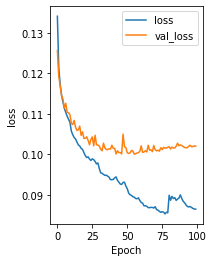

Test mse is 0.102
MSE for impact parameter is 0.10200
//////////////////
MSE for impact parameter is 6.62155, sqrt(MSE) = 2.57324


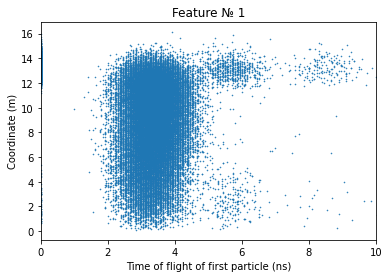

tensor([[ 1721.,  3950.],
        [  850., 34590.]])
tensor([[0.3035, 0.6965],
        [0.0240, 0.9760]])


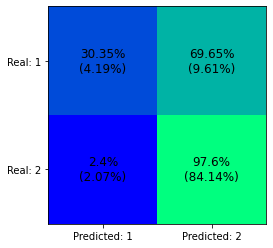

In [50]:
# График обучения и запись информации в файл
# print(net.out.weight)
# print(net.out.bias)

with torch.no_grad():
    
 
    plt.subplot(1,2,2)
    plt.plot(total_loss, label='loss')
    plt.plot(total_val_loss, label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    # if save_figures_dense:
    #     plt.savefig(name_of_image +  '_lin_learning.png', dpi=300)
    plt.show()
     
    test_predictions = net(test_features)
    test_mse = F.mse_loss(test_predictions, test_labels)

    print("Test mse is {:2.3f}" .format(test_mse))


    for idx in to_predict:
        idx_mod = 0 if n_out == 1 else idx
        # print(test_predictions.shape)

        preds = test_predictions[:,idx_mod]
        lbls = test_labels[:,idx_mod]



        print('MSE for {} is {:2.5f}'.format(name_of_label[idx], (F.mse_loss(preds, lbls))))
    print('//////////////////')
    for idx in to_predict:
        idx_mod = 0 if n_out == 1 else idx
        preds = denorm_label(test_predictions[:,idx_mod], idx)
        lbls = denorm_label(test_labels[:,idx_mod], idx)


        

        # print(preds[:10])
        # print(lbls[:10])
        sigma_sq = F.mse_loss(preds, lbls).item()
        print('MSE for {} is {:2.5f}, sqrt(MSE) = {:2.5f}'.format(name_of_label[idx], sigma_sq, np.sqrt(sigma_sq)))


        n_of_feature_to_plot = 1
        tpr_plt = torch.flatten(preds).to('cpu')
        tlb_plt = torch.flatten(lbls).to('cpu')
        tfe_plt = test_features[:,n_of_feature_to_plot].to('cpu') * norms[0]
        plt.scatter(tfe_plt, tlb_plt, s=dot_size)
        plt.xlim((0, 10))
        plt.xlabel('Time of flight of first particle (ns)')
        plt.ylabel('Coordinate (m)')
        plt.title(('Feature № ' + str(n_of_feature_to_plot)))
        # plt.savefig('Presentations/For_article/' + str(n_of_feature_to_plot) + '.png', dpi=300)
        plt.show()




    with open('regression_results.txt', 'a') as batch_results:
        batch_results.write('{}  lin: | {:7d}     | {:7.2f}  |'.format(name_of_file, batch_size, test_mse))


    conf_m_dense = get_correct_predictions_binary(test_predictions, test_labels[:,0], threshold)
    print(conf_m_dense)
    conf_m_normed_dense = torch.clone(conf_m_dense)

    for i in range(conf_m_dense.shape[0]):
        norm = conf_m_dense[i][0].item() + conf_m_dense[i][1].item()
        conf_m_normed_dense[i] /= norm
    print(conf_m_normed_dense)

    fig_dense, ax_dense = plt.subplots()
    im_dense = ax_dense.imshow(conf_m_normed_dense, cmap='winter')
    
    ax_dense.set_xticks(np.arange(conf_m_dense.shape[0]))
    ax_dense.set_yticks(np.arange(conf_m_dense.shape[1]))
    x_labels = []
    y_labels = []
    for i in range(conf_m_dense.shape[0]):
        x_labels.append('Predicted: '+ str(i + 1))
        y_labels.append('Real: ' + str(i + 1))
    ax_dense.set_xticklabels(x_labels)
    ax_dense.set_yticklabels(y_labels)
    # plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    for i in range(conf_m_dense.shape[0]):
        for j in range(conf_m_dense.shape[1]):
            cell_label = str(round(conf_m_normed_dense[i][j].item()*100, 2)) + '%\n(' + str(round(conf_m_dense[i][j].item()*100/test_features.shape[0], 2)) + '%)'
            # text = ax_dense.text(j, i, str(round(confusion_matrix_c[i][j].item()*100/test_features.shape[0],2)) + '%', ha="center", va="center", size=12)
            text = ax_dense.text(j, i, cell_label, ha="center", va="center", size=12)
    if save_figures_dense:
        plt.savefig((name_of_image + '_regr_dense_confM'), dpi=300)   


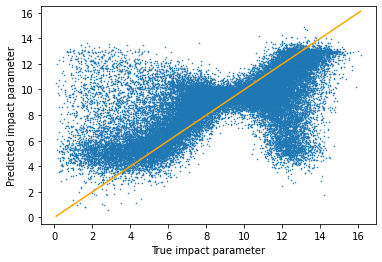

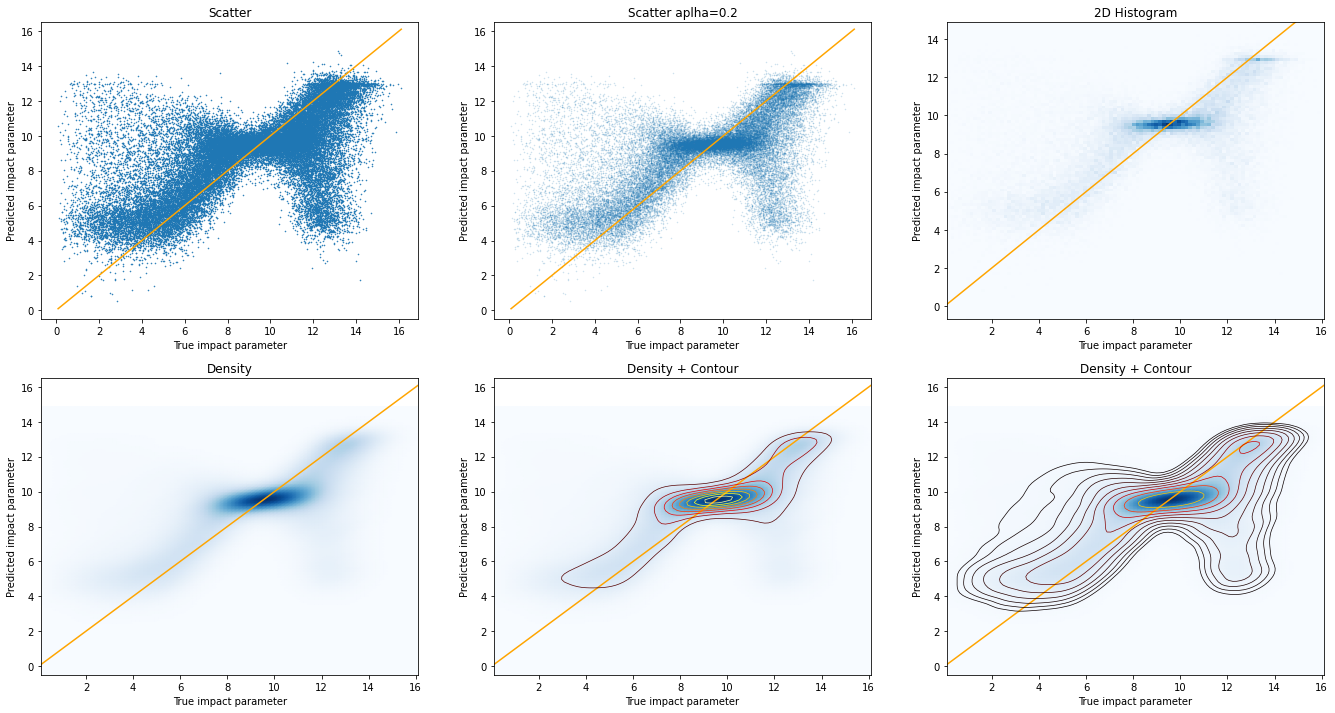

In [51]:
from scipy.stats import gaussian_kde

# Построение графиков
with torch.no_grad():
    for idx in to_predict:
        idx_mod = 0 if n_out == 1 else idx

        tlbl = denorm_label( np.array(test_labels[:,idx_mod].to('cpu')) , idx )                                              # Настоящие прицельные параметры
        tpr = denorm_label( np.array(test_predictions[:,idx_mod].to('cpu')), idx)                                          # Предсказанные 

        element_wise_diff = (tpr - tlbl)

        tdiff = np.array(element_wise_diff)                                       # Разница со знаком 
        tabsdiff = abs(np.array(element_wise_diff))                               # Разница без знака
        tmse = np.array((tpr - tlbl)**2)                                          # MSE


        # Зависимость Предсказанного параметра от Истинного
        max_val = max(tlbl)
        min_val = min(tlbl)
        plt.scatter(tlbl, tpr, s=dot_size)
        plt.plot([min_val, max_val], [min_val, max_val], color='orange')
        plt.xlabel('True ' + name_of_label[idx] )
        plt.ylabel('Predicted ' + name_of_label[idx])
        plt.ylim([-0.5,16.5])
        '''llim = 3.0
        rlim = 9.0
        plt.xlim(llim,rlim)
        plt.ylim(llim,rlim)'''
        if save_figures_dense:
            plt.savefig((name_of_image + '_'  + str(idx) + '_dense_pred'), dpi=300)
        plt.show() 



        # experimental plots
        fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(23, 12))
        for i in range(2):
            for j in range(3):
                axes[i][j].plot([min_val, max_val], [min_val, max_val], color='orange')
                axes[i][j].set_xlabel('True ' + name_of_label[idx] )
                axes[i][j].set_ylabel('Predicted ' + name_of_label[idx])
                axes[i][j].set_ylim([-0.5,16.5])

        nbins = 100
        for_kde = np.stack((tlbl, tpr), 0)
        k = gaussian_kde(for_kde)
        xi, yi = np.mgrid[tlbl.min():tlbl.max():nbins*1j, tpr.min():tpr.max():nbins*1j]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))

        axes[0][0].set_title("Scatter")
        axes[0][0].scatter(tlbl, tpr, s=dot_size)

        axes[0][1].set_title("Scatter aplha=0.2")
        axes[0][1].scatter(tlbl, tpr, s=dot_size, alpha=0.2)

        axes[0][2].set_title("2D Histogram")
        axes[0][2].hist2d(tlbl, tpr, bins=nbins, cmap=plt.cm.Blues)

        axes[1][0].set_title("Density")
        axes[1][0].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.Blues)

        axes[1][1].set_title("Density + Contour")
        axes[1][1].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.Blues)
        axes[1][1].contour(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.hot, linewidths=0.7, levels=8 )

        max_in_bin = zi.max() * tlbl.shape[0]
        helper = np.linspace(1.8, np.log10(max_in_bin), 11)
        levels = np.zeros_like(helper)
        for i in range(len(helper)):
            levels[i] = 10**helper[i] / tlbl.shape[0]

        axes[1][2].set_title("Density + Contour")
        axes[1][2].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.Blues)
        axes[1][2].contour(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.hot, linewidths=0.7, levels=levels )

        

        
        
        if save_figures_dense:
            plt.savefig((name_of_image + '_'  + str(idx) + '_dense_pred_experimental'), dpi=300)
        plt.show()

        '''
        # Зависимость Разницы от Истинного прицельного параметра
        plt.scatter(tlbl, tdiff, s=dot_size)
        plt.xlabel('True ' + name_of_label[idx] )
        plt.ylabel('Difference')
        plt.show() 

        # Зависимость Модуля Разницы от Истинного прицельного параметра
        plt.scatter(tlbl, tabsdiff, s=dot_size)
        plt.xlabel('True ' + name_of_label[idx] )
        plt.ylabel('Difference')
        plt.show() 

        # Зависимость MSE от Истинного прицельного параметра
        plt.scatter(tlbl, tmse, s=dot_size)
        plt.xlabel('True ' + name_of_label[idx] )
        plt.ylabel('MSE')
        plt.show()
        ''' 



In [52]:
# Объявление класса сверточной сети
class NetworkConv(nn.Module):
    def __init__(self):
        super(NetworkConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(n_lines, 6), stride=(1, 2))
        # self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(n_lines, 40), stride=(1, 40))
        nn.init.normal_(self.conv1.weight, mean=0.0, std=0.02)
        

        self.conv_outp_features = int((maximum_hits)/2 - 2)

        # self.lin1 = nn.Linear(in_features=n_detectors*2*5*3, out_features=60)
        if include_coord_feature:
            self.lin1 = nn.Linear(in_features=self.conv1.out_channels*(int(self.conv_outp_features )) + 1, out_features=128)
        else:
            self.lin1 = nn.Linear(in_features=self.conv1.out_channels*(int(self.conv_outp_features )), out_features=128)
        nn.init.normal_(self.lin1.weight, mean=0.0, std=0.02)
        
        self.lin2 = nn.Linear(in_features=self.lin1.out_features, out_features=64)
        nn.init.normal_(self.lin2.weight, mean=0.0, std=0.02)

        self.lin3 = nn.Linear(in_features=self.lin2.out_features, out_features=32)
        nn.init.normal_(self.lin3.weight, mean=0.0, std=0.02)


        self.out = nn.Linear(in_features=self.lin3.out_features, out_features=n_out)
        nn.init.normal_(self.out.weight, mean=0.0, std=0.02)
        
    def forward(self, t):
        if include_coord_feature:
            main_part = t[:,:number_of_features - 1]
            coord_part = torch.reshape(t[:,number_of_features - 1], (-1, 1))
            t = torch.reshape(main_part, (-1, 1, n_lines, maximum_hits))
        else:
            t = torch.reshape(t, (-1, 1, n_lines, maximum_hits))
        
        t = F.relu(self.conv1(t))
        
        # t = F.relu(self.conv2(t))
        # t = torch.reshape(t, (-1, self.conv1.out_channels, self.conv_outp_features))
        # t = self.maxpool1d(t)
        
        t = torch.reshape(t, (-1, int(self.conv1.out_channels * self.conv_outp_features )))
        if include_coord_feature:
            t = torch.cat((t, coord_part), axis=1)
        t = F.relu(self.lin1(t))
        t = F.relu(self.lin2(t))
        t = F.relu(self.lin3(t))
        
        t = self.out(t)
        return t


In [53]:
# В этом блоке - сам процесс обучения
net_c = NetworkConv().to(device)
print(net_c)
optimizer_c = optim.Adam(net_c.parameters(), lr=0.001)

total_loss_c = []
total_val_loss_c = []

# Learning process
for epoch in range(number_of_epoches_conv):
    t_loss = 0
    idx = int(epoch * 10 / number_of_epoches_conv)
    if undersampling_enable or oversampling_enable:
        batch_size = int(divisors[idx] / 2)
    else: 
        batch_size = divisors[idx]
        # batch_size = batch_size_N

    if undersampling_enable :
        trDL = torch.utils.data.DataLoader(trDS_undersampling, batch_size=batch_size, shuffle=True)
    elif oversampling_enable:
        trDL = torch.utils.data.DataLoader(trDS_oversampling, batch_size=batch_size, shuffle=True)
    elif is_made_uniform_batch:
        trDL = torch.utils.data.DataLoader(trDS_uniform, batch_size=batch_size, shuffle=True)
    else:
        trDL = torch.utils.data.DataLoader(trDS, batch_size=batch_size, shuffle=True)



    for batch in trDL:
        batch_labels = (batch['label']).reshape((-1,1)).type(torch.FloatTensor).to(device)
        batch_features = batch['feature'].type(torch.FloatTensor).to(device)

        if undersampling_enable or oversampling_enable:
            batch_labels = torch.reshape(batch_labels, (-1, train_labels_low.shape[1]))
            batch_features = torch.reshape(batch_features, (-1, train_features_low.shape[1]))

        predicted = net_c(batch_features)


        loss = loss_with_weights(predicted, batch_labels, boost_low=false)
        optimizer_c.zero_grad()
        loss.backward()
        optimizer_c.step()

        t_loss += (loss.item() * batch_size/len(trDS))

    
    with torch.no_grad():  # record loss and accuracy info for plots
        total_loss_c.append(t_loss)

        test_preds = net_c(test_features)
        test_loss = loss_with_weights(test_preds, test_labels, boost_low=false)
        total_val_loss_c.append(test_loss.item())

        print("Epoch: {:4d} |---> train loss is {:4.10f}, validation loss is {:4.10f}, {}"
            .format(epoch, t_loss, test_loss, batch_size))

NetworkConv(
  (conv1): Conv2d(1, 16, kernel_size=(3, 6), stride=(1, 2))
  (lin1): Linear(in_features=448, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)
Epoch:    0 |---> train loss is 0.1395125344, validation loss is 0.1290629561, 400
Epoch:    1 |---> train loss is 0.1262170051, validation loss is 0.1251392246, 400
Epoch:    2 |---> train loss is 0.1233328790, validation loss is 0.1228799841, 400
Epoch:    3 |---> train loss is 0.1209350094, validation loss is 0.1201597422, 400
Epoch:    4 |---> train loss is 0.1183436238, validation loss is 0.1185345038, 400
Epoch:    5 |---> train loss is 0.1166845861, validation loss is 0.1166465661, 400
Epoch:    6 |---> train loss is 0.1160553268, validation loss is 0.1164178007, 400
Epoch:    7 |---> train loss is 0.1146525904, validation loss is 0.1155247181, 400
Epoch:    8 |---

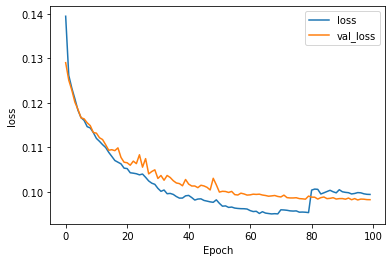

Test mse is 0.10
MSE for impact parameter is 0.098
//////////////////
MSE for impact parameter is 6.376, sqrt(MSE) = 2.525
tensor([[ 1161.,  4510.],
        [  499., 34941.]])
tensor([[0.2047, 0.7953],
        [0.0141, 0.9859]])


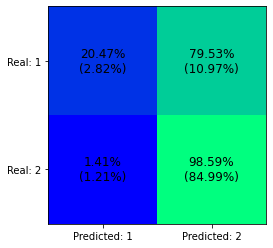

In [54]:
# График обучения и запись информации в файл
with torch.no_grad():
    
    plt.plot(total_loss_c, label='loss')
    plt.plot(total_val_loss_c, label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    # if save_figures_conv:
    #     plt.savefig(name_of_image +  '_conv_learning.png', dpi=300)
    plt.show()
    
    test_predictions_c = net_c(test_features)
    test_mse_c = F.mse_loss(test_predictions_c, test_labels)

    zero_features = torch.zeros((1,number_of_features)).to(device)
    zero_preds = net_c(zero_features)
    zero_preds_denorm = np.zeros(n_out)
    # print(zero_preds)
    for idx in to_predict:
        idx_mod = 0 if n_out == 1 else idx
        zero_preds_denorm[idx_mod] = denorm_label(zero_preds[:,idx_mod].item(), idx)
    # print(zero_preds_denorm)
    # print(maximum_values)
    print("Test mse is {:2.2f}" .format(test_mse_c))

    for idx in to_predict:
        idx_mod = 0 if n_out == 1 else idx
        preds = test_predictions_c[:,idx_mod]
        lbls = test_labels[:,idx_mod]
        print('MSE for {} is {:2.3f}'.format(name_of_label[idx], (F.mse_loss(preds, lbls))))
    print('//////////////////')
    for idx in to_predict:
        idx_mod = 0 if n_out == 1 else idx
        preds = denorm_label(test_predictions_c[:,idx_mod], idx)
        lbls = denorm_label(test_labels[:,idx_mod], idx)

        # print(preds[:10])
        # print(lbls[:10])
        sigma_sq = F.mse_loss(preds, lbls).item()
        print('MSE for {} is {:2.3f}, sqrt(MSE) = {:2.3f}'.format(name_of_label[idx], sigma_sq, np.sqrt(sigma_sq)))

    
    with open('regression_results.txt', 'a') as batch_results:
        batch_results.write('      {}  conv: | {:7d}     | {:7.2f}  |\n'.format(name_of_file, batch_size, test_mse_c))  




    conf_m = get_correct_predictions_binary(test_predictions_c, test_labels[:,0], threshold)
    print(conf_m)
    conf_m_normed = torch.clone(conf_m)

    for i in range(conf_m.shape[0]):
        norm = conf_m[i][0].item() + conf_m[i][1].item()
        conf_m_normed[i] /= norm
    print(conf_m_normed)

    fig, ax = plt.subplots()
    im = ax.imshow(conf_m_normed, cmap='winter')
    
    ax.set_xticks(np.arange(conf_m.shape[0]))
    ax.set_yticks(np.arange(conf_m.shape[1]))
    x_labels = []
    y_labels = []
    for i in range(conf_m.shape[0]):
        x_labels.append('Predicted: '+ str(i + 1))
        y_labels.append('Real: ' + str(i + 1))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    # plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    for i in range(conf_m.shape[0]):
        for j in range(conf_m.shape[1]):
            cell_label = str(round(conf_m_normed[i][j].item()*100, 2)) + '%\n(' + str(round(conf_m[i][j].item()*100/test_features.shape[0], 2)) + '%)'
            # text = ax.text(j, i, str(round(confusion_matrix_c[i][j].item()*100/test_features.shape[0],2)) + '%', ha="center", va="center", size=12)
            text = ax.text(j, i, cell_label, ha="center", va="center", size=12)
    if save_figures_conv:
        plt.savefig((name_of_image + '_regr_conv_confM'), dpi=300)


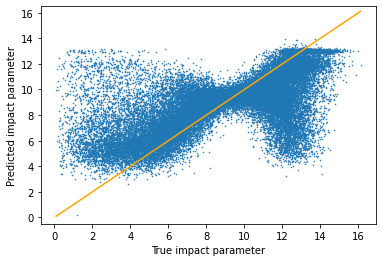

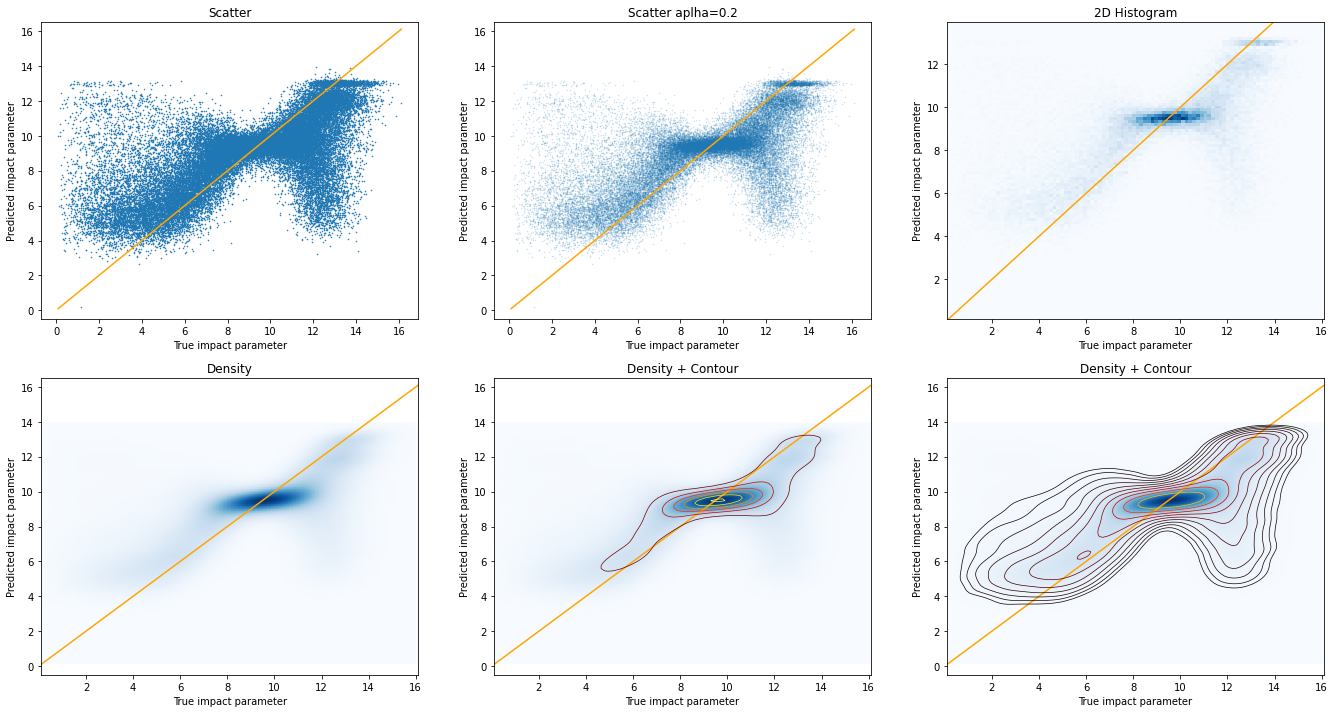

In [55]:
# Построение графиков
with torch.no_grad():
    # print(zero_preds_denorm)
    for idx in to_predict:
        idx_mod = 0 if n_out == 1 else idx
        tlbl = denorm_label( np.array(test_labels[:,idx_mod].to('cpu')) , idx )                                              # Настоящие прицельные параметры
        tpr_c = denorm_label( np.array(test_predictions_c[:,idx_mod].to('cpu')), idx)                                          # Предсказанные 
        

        element_wise_diff_c = (tpr_c - tlbl)

        tdiff_c = np.array(element_wise_diff_c)                                       # Разница со знаком 
        tabsdiff_c = abs(np.array(element_wise_diff_c))                               # Разница без знака
        tmse_c = np.array((tpr_c - tlbl)**2)                                         # MSE



        # Зависимость Предсказанного параметра от Истинного
        max_val = max(tlbl)
        min_val = min(tlbl)
        plt.scatter(tlbl, tpr_c, s=dot_size)
        plt.plot([min_val, max_val], [min_val, max_val], color='orange')
        #plt.plot([min_val, max_val],[zero_preds_denorm[idx_mod], zero_preds_denorm[idx_mod]], color='red', linewidth=0.5 )
        plt.xlabel('True ' + name_of_label[idx] )
        plt.ylabel('Predicted ' + name_of_label[idx])
        plt.ylim([-0.5,16.5])
        if save_figures_conv:
            plt.savefig((name_of_image + '_' + str(idx) + '_conv_pred'), dpi=300)
        plt.show() 

        
        # experimental plots
        fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(23, 12))
        for i in range(2):
            for j in range(3):
                axes[i][j].plot([min_val, max_val], [min_val, max_val], color='orange')
                axes[i][j].set_xlabel('True ' + name_of_label[idx] )
                axes[i][j].set_ylabel('Predicted ' + name_of_label[idx])
                axes[i][j].set_ylim([-0.5,16.5])

        nbins = 100
        for_kde = np.stack((tlbl, tpr_c), 0)
        k = gaussian_kde(for_kde)
        xi, yi = np.mgrid[tlbl.min():tlbl.max():nbins*1j, tpr_c.min():tpr_c.max():nbins*1j]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))

        axes[0][0].set_title("Scatter")
        axes[0][0].scatter(tlbl, tpr_c, s=dot_size)

        axes[0][1].set_title("Scatter aplha=0.2")
        axes[0][1].scatter(tlbl, tpr_c, s=dot_size, alpha=0.2)

        axes[0][2].set_title("2D Histogram")
        axes[0][2].hist2d(tlbl, tpr_c, bins=nbins, cmap=plt.cm.Blues)

        axes[1][0].set_title("Density")
        axes[1][0].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.Blues)

        axes[1][1].set_title("Density + Contour")
        axes[1][1].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.Blues)
        axes[1][1].contour(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.hot, linewidths=0.7, levels=8 )

        max_in_bin = zi.max() * tlbl.shape[0]
        helper = np.linspace(1.8, np.log10(max_in_bin), 11)
        levels = np.zeros_like(helper)
        for i in range(len(helper)):
            levels[i] = 10**helper[i] / tlbl.shape[0]

        axes[1][2].set_title("Density + Contour")
        axes[1][2].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.Blues)
        axes[1][2].contour(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.hot, linewidths=0.7, levels=levels )

        

        
        
        if save_figures_conv:
            plt.savefig((name_of_image + '_'  + str(idx) + '_conv_pred_experimental'), dpi=300)
        plt.show()
        '''
        # Зависимость Разницы от Истинного прицельного параметра
        plt.scatter(tlbl, tdiff_c, s=dot_size)
        plt.xlabel('True ' + name_of_label[idx] )
        plt.ylabel('Difference')
        # plt.savefig((name_of_image + str(idx) + '_diff'), dpi=300)
        plt.show()

        # Зависимость Модуля Разницы от Истинного прицельного параметра
        plt.scatter(tlbl, tabsdiff_c, s=dot_size)
        plt.xlabel('True ' + name_of_label[idx] )
        plt.ylabel('Abs difference')
        # plt.savefig((name_of_image + str(idx) + '_adiff'), dpi=300)
        plt.show() 
 

        # Зависимость MSE от Истинного прицельного параметра
        plt.scatter(tlbl, tmse_c, s=dot_size)
        plt.xlabel('True ' + name_of_label[idx] )
        plt.ylabel('MSE')
        # plt.savefig((name_of_image + str(idx) + '_mse'), dpi=300)
        plt.show() 
        '''